In [1]:
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================
The dataset used in this example is a preprocessed except of the
"Labeled Faces in the Wild", aka LFW_:
  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)
  .. _LFW: http://vis-www.cs.umass.edu/lfw/
  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html
"""



print __doc__

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes


###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)


###############################################################################
# Train a SVM classification model

print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_


###############################################################################
# Quantitative evaluation of the model quality on the test set

print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()


Faces recognition example using eigenfaces and SVMs
The dataset used in this example is a preprocessed except of the
"Labeled Faces in the Wild", aka LFW_:
  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)
  .. _LFW: http://vis-www.cs.umass.edu/lfw/
  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html



/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
2018-02-05 20:15:30,243 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2018-02-05 20:15:33,347 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2018-02-05 20:15:34,515 Downloading LFW metadata: https://ndownloader.figshare.com/files

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces


/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 1.402s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.050s
Fitting the classifier to the training set
done in 22.928s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.063s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.81      0.85      0.83        60
  Donald Rumsfeld       0.70      0.78      0.74        27
    George W Bush       0.90      0.90      0.90       146
Gerhard Schroeder       0.80      0.80      0.80        25
      Hugo Chavez       0.90      0.60      0.72        15
       Tony Blair       0.91      0.83      0.87        36

      avg / total       0.85      0.84     

i=15

Faces recognition example using eigenfaces and SVMs
The dataset used in this example is a preprocessed except of the
"Labeled Faces in the Wild", aka LFW_:
  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)
  .. _LFW: http://vis-www.cs.umass.edu/lfw/
  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 15 eigenfaces from 966 faces
done in 0.056s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.014s
Fitting the classifier to the training set


/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 16.969s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.018s
                   precision    recall  f1-score   support

     Ariel Sharon       0.36      0.31      0.33        13
     Colin Powell       0.67      0.75      0.71        60
  Donald Rumsfeld       0.58      0.56      0.57        27
    George W Bush       0.74      0.77      0.76       146
Gerhard Schroeder       0.52      0.44      0.48        25
      Hugo Chavez       0.58      0.47      0.52        15
       Tony Blair       0.55      0.50      0.52        36

      avg / total       0.65      0.66      0.66       322

[[  4   5   1   3   0   0   0]
 [  5  45   1   9   0   0   0]
 [  0   3  15   9   0   0   0]
 [  1  10   8 113   6   2  

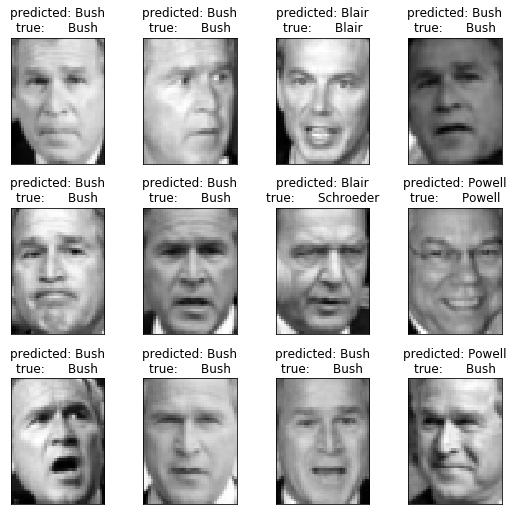

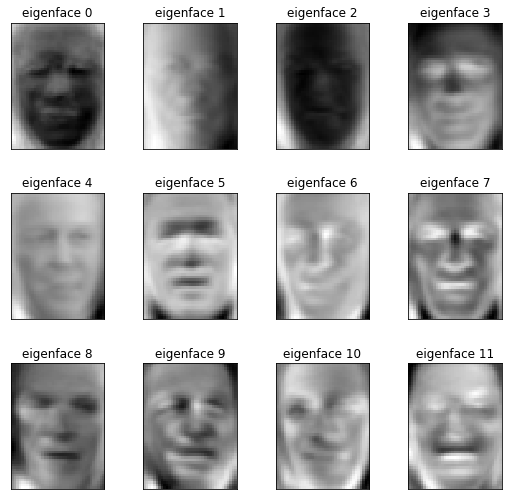

[ 501385.3125      392114.1875      183783.015625    154250.75        133745.375
   74823.8515625    65250.546875     56362.38671875   52244.98828125
   49238.046875     43522.01953125   40707.5390625    31358.54492188
   27863.828125     27290.24609375]
i=25

Faces recognition example using eigenfaces and SVMs
The dataset used in this example is a preprocessed except of the
"Labeled Faces in the Wild", aka LFW_:
  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)
  .. _LFW: http://vis-www.cs.umass.edu/lfw/
  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 25 eigenfaces from 966 faces


/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.163s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.031s
Fitting the classifier to the training set
done in 10.265s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.015s
                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.62      0.57        13
     Colin Powell       0.67      0.85      0.75        60
  Donald Rumsfeld       0.58      0.56      0.57        27
    George W Bush       0.88      0.83      0.86       146
Gerhard Schroeder       0.68      0.60      0.64        25
      Hugo Chavez       0.77      0.67      0.71        15
       Tony Blair       0.70      0.64      0.67        36

      avg / total       0.76      0.75      

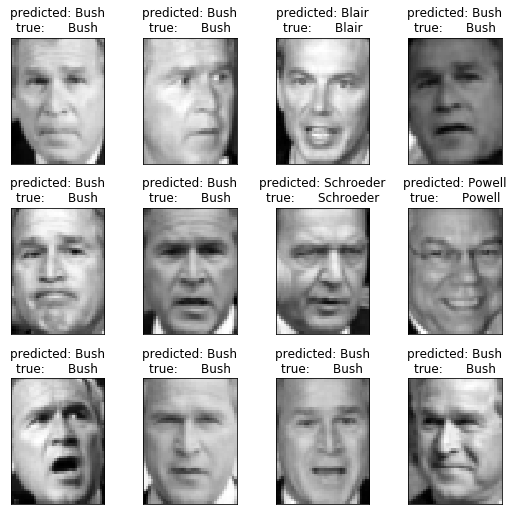

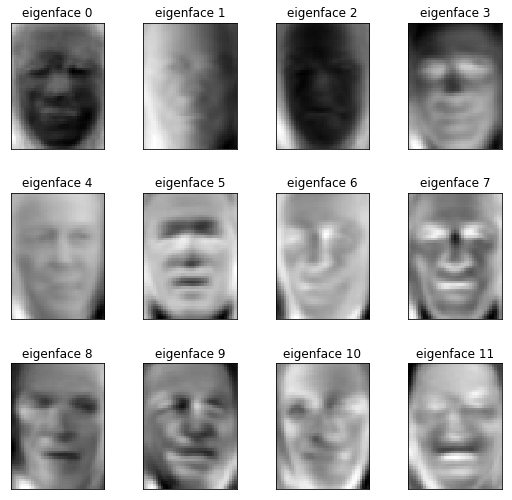

[ 501384.75        392114.5625      183783.53125     154252.15625
  133746.265625     74868.46875      65251.58203125   56413.34375
   52368.4140625    49336.68359375   43618.26171875   40981.84375
   31672.21875      28165.01367188   27526.54101562   25356.1484375
   23088.8671875    22048.80273438   21569.66796875   18385.8828125
   17802.91992188   15873.73046875   15665.32226562   14058.04003906
   13226.73339844]
i=50

Faces recognition example using eigenfaces and SVMs
The dataset used in this example is a preprocessed except of the
"Labeled Faces in the Wild", aka LFW_:
  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)
  .. _LFW: http://vis-www.cs.umass.edu/lfw/
  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 50 eigenfaces from 966 faces


/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.106s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.015s
Fitting the classifier to the training set
done in 7.529s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.024s
                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.69      0.67        13
     Colin Powell       0.82      0.88      0.85        60
  Donald Rumsfeld       0.68      0.56      0.61        27
    George W Bush       0.87      0.90      0.89       146
Gerhard Schroeder       0.73      0.76      0.75        25
      Hugo Chavez       0.79      0.73      0.76        15
       Tony Blair       0.86      0.69      0.77        36

      avg / total       0.82      0.82      0

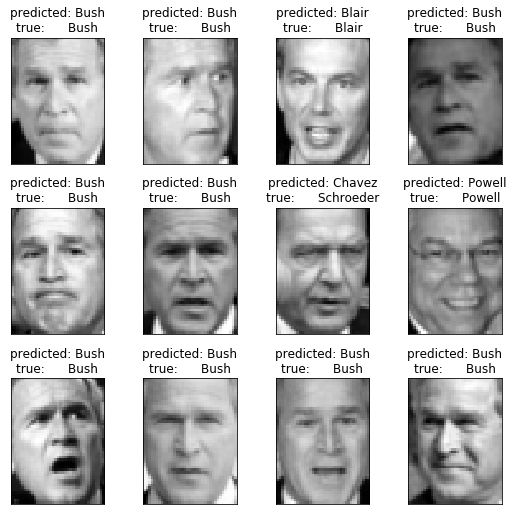

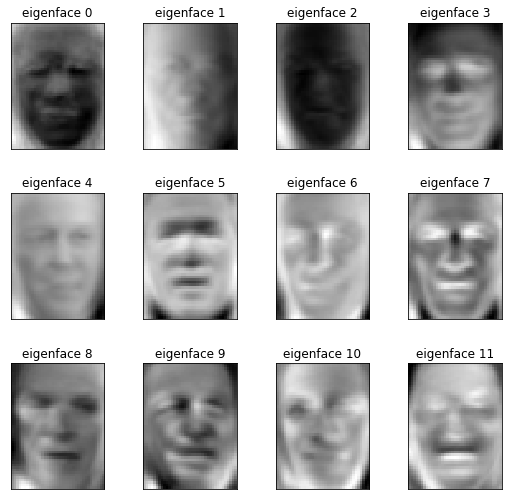

[ 501385.375       392114.8125      183783.65625     154252.53125
  133746.59375      74871.84375      65257.015625     56423.96875
   52377.01171875   49340.51171875   43621.84375      41001.65625
   31703.9609375    28215.19335938   27597.56640625   25405.29492188
   23140.27734375   22158.75195312   21665.25390625   18732.51367188
   18057.52539062   16936.42773438   16549.45898438   14476.53320312
   13666.23632812   13431.45800781   13130.90234375   12520.53710938
   11415.27734375   10781.81347656   10131.55175781    9767.5078125
    9058.            8901.13769531    8546.28417969    8283.24121094
    8057.74072266    7395.93701172    7348.23974609    7080.35791016
    6906.54296875    6644.83837891    6482.42578125    6269.27099609
    5949.64453125    5783.01611328    5487.57714844    5341.32763672
    5249.50634766    5219.09423828]
i=100

Faces recognition example using eigenfaces and SVMs
The dataset used in this example is a preprocessed except of the
"Labeled Faces in the 

/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.198s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.020s
Fitting the classifier to the training set
done in 13.582s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.043s
                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.69      0.67        13
     Colin Powell       0.82      0.88      0.85        60
  Donald Rumsfeld       0.77      0.63      0.69        27
    George W Bush       0.89      0.96      0.92       146
Gerhard Schroeder       0.86      0.76      0.81        25
      Hugo Chavez       0.90      0.60      0.72        15
       Tony Blair       0.87      0.75      0.81        36

      avg / total       0.85      0.85     

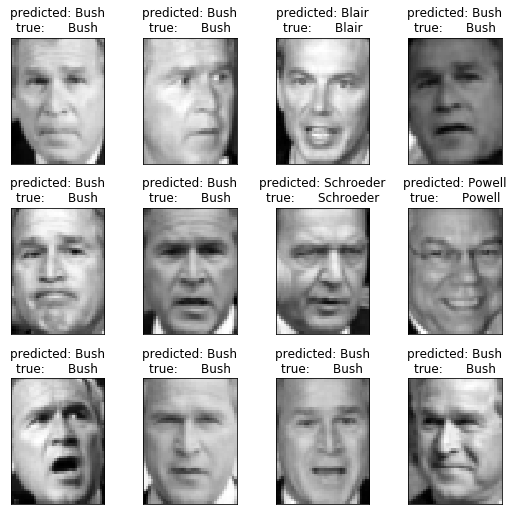

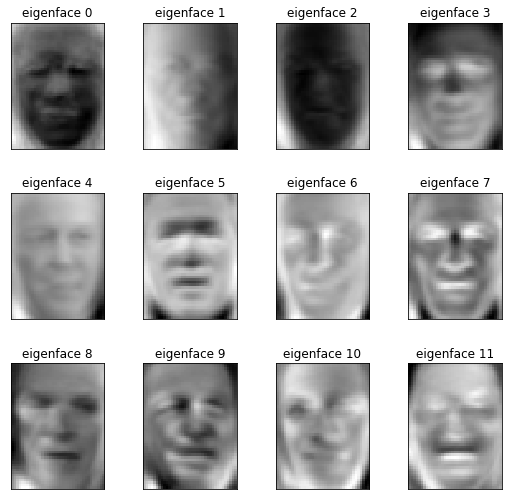

[ 501385.75        392114.5625      183783.703125    154252.328125
  133746.546875     74871.859375     65257.03125      56424.0390625
   52377.32421875   49340.82421875   43622.2265625    41002.4921875
   31706.0546875    28218.59960938   27600.18359375   25408.80273438
   23144.96484375   22162.06640625   21672.3203125    18743.53320312
   18062.14648438   16961.20898438   16586.90234375   14564.33203125
   13772.81542969   13488.62109375   13162.60351562   12555.18945312
   11504.38085938   10834.66601562   10204.34179688    9906.70410156
    9231.90820312    9107.21972656    8678.61621094    8552.48828125
    8160.89355469    7677.81933594    7520.44677734    7378.56884766
    7251.17871094    6937.13378906    6733.04248047    6691.74707031
    6241.38671875    6179.68310547    6088.63232422    5758.66064453
    5613.86083984    5599.36914062    5412.04248047    5310.41845703
    5181.17138672    5111.78271484    5012.48242188    4882.87939453
    4634.98925781    4619.51855469    

/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.800s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.031s
Fitting the classifier to the training set
done in 36.828s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.096s
                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.69      0.60        13
     Colin Powell       0.77      0.88      0.82        60
  Donald Rumsfeld       0.90      0.67      0.77        27
    George W Bush       0.88      0.89      0.88       146
Gerhard Schroeder       0.76      0.76      0.76        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.81      0.72      0.76        36

      avg / total       0.83      0.82     

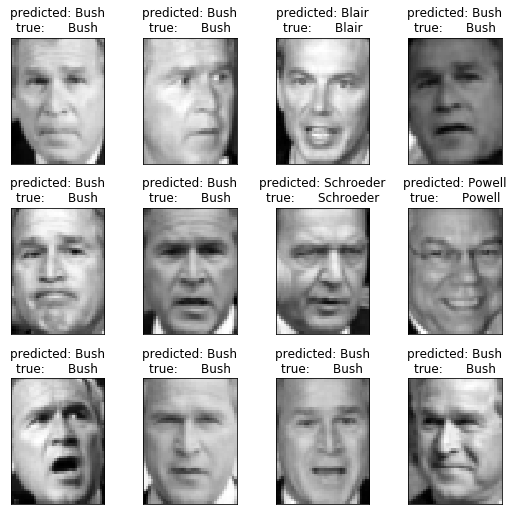

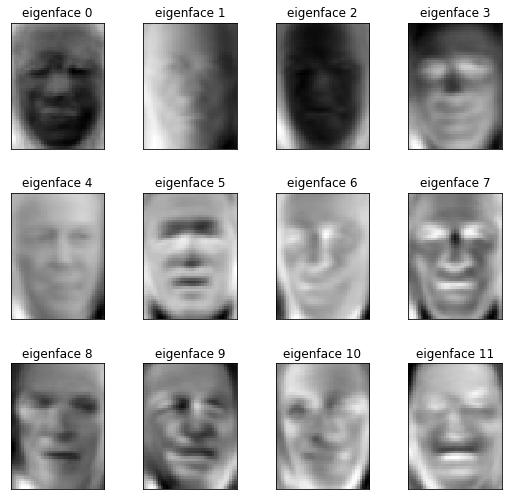

[  5.01384062e+05   3.92115031e+05   1.83783312e+05   1.54252234e+05
   1.33746359e+05   7.48717578e+04   6.52570000e+04   5.64240430e+04
   5.23773047e+04   4.93408438e+04   4.36222109e+04   4.10024805e+04
   3.17060469e+04   2.82186367e+04   2.76001836e+04   2.54088262e+04
   2.31450371e+04   2.21621484e+04   2.16723438e+04   1.87437969e+04
   1.80622578e+04   1.69614316e+04   1.65871230e+04   1.45645742e+04
   1.37733945e+04   1.34895371e+04   1.31635928e+04   1.25556729e+04
   1.15053760e+04   1.08358740e+04   1.02062090e+04   9.90758105e+03
   9.23350293e+03   9.10985059e+03   8.68127051e+03   8.55837402e+03
   8.16271387e+03   7.68442041e+03   7.52711914e+03   7.38668457e+03
   7.25371826e+03   6.94303369e+03   6.74090088e+03   6.70110205e+03
   6.24824316e+03   6.20157520e+03   6.09897803e+03   5.77242090e+03
   5.63778662e+03   5.61645996e+03   5.42085938e+03   5.32834863e+03
   5.19969873e+03   5.12194727e+03   5.02871240e+03   4.90295020e+03
   4.67141211e+03   4.64185840e+03

In [6]:
def iterate(n_components):   
    """
    ===================================================
    Faces recognition example using eigenfaces and SVMs
    ===================================================
    The dataset used in this example is a preprocessed except of the
    "Labeled Faces in the Wild", aka LFW_:
      http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)
      .. _LFW: http://vis-www.cs.umass.edu/lfw/
      original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html
    """



    print __doc__

    from time import time
    import logging
    import pylab as pl
    import numpy as np

    from sklearn.cross_validation import train_test_split
    from sklearn.datasets import fetch_lfw_people
    from sklearn.grid_search import GridSearchCV
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.decomposition import RandomizedPCA
    from sklearn.svm import SVC
    %matplotlib inline

    # Display progress logs on stdout
    logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


    ###############################################################################
    # Download the data, if not already on disk and load it as numpy arrays
    lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

    # introspect the images arrays to find the shapes (for plotting)
    n_samples, h, w = lfw_people.images.shape
    np.random.seed(42)

    # for machine learning we use the data directly (as relative pixel
    # position info is ignored by this model)
    X = lfw_people.data
    n_features = X.shape[1]

    # the label to predict is the id of the person
    y = lfw_people.target
    target_names = lfw_people.target_names
    n_classes = target_names.shape[0]

    print "Total dataset size:"
    print "n_samples: %d" % n_samples
    print "n_features: %d" % n_features
    print "n_classes: %d" % n_classes


    ###############################################################################
    # Split into a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    ###############################################################################
    # Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
    # dataset): unsupervised feature extraction / dimensionality reduction
    n_components = n_components

    print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
    t0 = time()
    pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
    print "done in %0.3fs" % (time() - t0)

    eigenfaces = pca.components_.reshape((n_components, h, w))

    print "Projecting the input data on the eigenfaces orthonormal basis"
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print "done in %0.3fs" % (time() - t0)


    ###############################################################################
    # Train a SVM classification model

    print "Fitting the classifier to the training set"
    t0 = time()
    param_grid = {
             'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              }
    # for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(X_train_pca, y_train)
    print "done in %0.3fs" % (time() - t0)
    print "Best estimator found by grid search:"
    print clf.best_estimator_


    ###############################################################################
    # Quantitative evaluation of the model quality on the test set

    print "Predicting the people names on the testing set"
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print "done in %0.3fs" % (time() - t0)

    print classification_report(y_test, y_pred, target_names=target_names)
    print confusion_matrix(y_test, y_pred, labels=range(n_classes))


    ###############################################################################
    # Qualitative evaluation of the predictions using matplotlib

    def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
        """Helper function to plot a gallery of portraits"""
        pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
        pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
        for i in range(n_row * n_col):
            pl.subplot(n_row, n_col, i + 1)
            pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
            pl.title(titles[i], size=12)
            pl.xticks(())
            pl.yticks(())


    # plot the result of the prediction on a portion of the test set

    def title(y_pred, y_test, target_names, i):
        pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
        true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
        return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

    prediction_titles = [title(y_pred, y_test, target_names, i)
                             for i in range(y_pred.shape[0])]

    plot_gallery(X_test, prediction_titles, h, w)

    # plot the gallery of the most significative eigenfaces

    eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
    plot_gallery(eigenfaces, eigenface_titles, h, w)

    pl.show()
    print pca.explained_variance_

for i in [15, 25, 50, 100, 250]:
    print "i={}".format(i)
    iterate(i)

In [ ]:
                  precision    recall  f1-score   support

     Ariel Sharon       0.10      0.15      0.12        13
     Colin Powell       0.44      0.50      0.47        60
  Donald Rumsfeld       0.25      0.37      0.30        27
    George W Bush       0.69      0.60      0.64       146
Gerhard Schroeder       0.19      0.20      0.20        25
      Hugo Chavez       0.18      0.13      0.15        15
       Tony Blair       0.47      0.39      0.42        36

      avg / total       0.50      0.47      0.48       322